# Tutorial:  Read MAGIC calibrated ROOT data into ctapipe
---

&copy; Ievgen Vovk, Lab Saha, Moritz Hütten, David Green, for the LST-I bootcamp 11/2018

---

In [1]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 0. MAGIC camera geometry and optics

The telescope optics information is read from the information stored in `ctapipe-extra`. The specifications of the MAGIC optical system can be read without loading the data. For details please refer to the first notebook `magic_lst_mc_event_viewer.ipynb`.

## 1. Loading the data

In this session we will load "calibrated" MAGIC data files. These contain the calibrated charge and peak position maps - just like DL1 CTA data.
 
Calibrated MAGIC data have the suffix `_Y_` in their names.

During data taking, each data run is split into several sub-runs, stored in separate files. Also MAGIC-I and MAGIC-II data are stored to separately. Due to this we will use a wildcard to select all the files we need and let the reader organize them into "runs".

Note: presently the reader loads all subruns of the specified runs, even if your wildcard tells otherwise.

Anyway, lets load some data.

In [2]:
from ctapipe.io import EventSourceFactory
import time

In [3]:
file_mask = "MAGIC_calibrated_05029747/20*root"

tstart = time.time()
event_factory = EventSourceFactory.produce(input_url=file_mask)
tstop = time.time()

print("Event source preparation took {:.2f} sec".format(tstop - tstart))
print("Runs in the sample:", event_factory.run_numbers)

FileNotFoundError: [Errno 2] No such file or directory: 'MAGIC_calibrated_05029747/20*root'

At this preparation step the files satisfying the wild card are located and corresponding data runs identified. As you see, we currently have a single run.

### Reading the events

**Note:** to read MAGIC data files one needs to install the `uproot` package.

**Note:** reading of these data may consume substantial part of your RAM.

To form stereo images, both MAGIC-I and MAGIC-II data have to be loaded at the same time. For technical reasons, proper stereo matching between the telescope requires loading of the entire run into the memory. So you may expect large (1-5 Gb) memory consumption (will be smaller on our reduced data sample).

The initial startup needs some time to load and identify stereo/mono/pedestal events in the files.

#### Read the run:

In [4]:
tstart = time.time()
run = event_factory._set_active_run(event_factory.run_numbers[0])
tstop = time.time()

print(run)
print("")
print("Reading of the run took {:.2f} sec".format(tstop - tstart))
print("")
print("Stereo events in run:", run['data'].n_stereo_events)
print("Mono events in run:", run['data'].n_mono_events_m1 + run['data'].n_mono_events_m2)
print("Pedestal events in run:", run['data'].n_pedestal_events_m1 + run['data'].n_pedestal_events_m2)

{'number': 5029747, 'read_events': 0, 'data': <ctapipe.io.magiceventsource.MarsDataRun object at 0x7f627f53f7b8>}

Reading of the run took 8.17 sec

Stereo events in run: 21924
Mono events in run: 2681
Pedestal events in run: 4491


#### Read stereo events:

In [5]:
tstart = time.time()
stereo_event_generator = event_factory._generator()
count = 0
for stereo_event in stereo_event_generator:
    count += 1    
tstop = time.time()

print("Reading {:d} stereo events took {:.2f} sec".format(count,tstop - tstart))

Reading 21924 stereo events took 21.76 sec


Using the simple standard syntax does the event source preparation and merging at once, selecting only stereo events. 

In [6]:
from ctapipe.io import event_source

tstart = time.time()
stereo_events = event_source(input_url=file_mask, max_events=7)
count = 0
for stereo_event in stereo_events:
    count += 1  
    print("Oder num: {:d}, event id: {:.0f}, triggered telescopes: {}".format(stereo_event.count, stereo_event.r0.event_id, stereo_event.r0.tels_with_data))  
tstop = time.time()

print("Reading of the first {:d} stereo events took {:.2f} sec".format(count, tstop - tstart))

Oder num: 0, event id: 29795, triggered telescopes: {1, 2}
Oder num: 1, event id: 29797, triggered telescopes: {1, 2}
Oder num: 2, event id: 29798, triggered telescopes: {1, 2}
Oder num: 3, event id: 29799, triggered telescopes: {1, 2}
Oder num: 4, event id: 29802, triggered telescopes: {1, 2}
Oder num: 5, event id: 29805, triggered telescopes: {1, 2}
Oder num: 6, event id: 29807, triggered telescopes: {1, 2}
Reading of the first 7 stereo events took 8.14 sec


#### Read mono events:

"Mono" events are those that do not have a stereo counterpart in the files: either due us incomplete data run loaded (like we did) or other issues. However, they can still be procesed.

In [7]:
tstart = time.time()
mono_event_generator = event_factory._mono_event_generator(telescope='M1')
count = 0
for m1_mono_event in mono_event_generator:
    count += 1       
tstop = time.time()

print("Reading of {:d} M1 mono events took {:.2f} sec".format(count,tstop - tstart))

Reading of 1442 M1 mono events took 8.62 sec


In [8]:
tstart = time.time()
mono_event_generator = event_factory._mono_event_generator(telescope='M2')
count = 0
for m2_mono_event in mono_event_generator:
    count += 1        
tstop = time.time()

print("Reading of {:d} M2 mono events took {:.2f} sec".format(count,tstop - tstart))

Reading of 1239 M2 mono events took 8.54 sec


#### Read pedestal events:

Pedestal events are those taken with no data trigger. They contain only the electronic noise and signal from the night sky (stars + air glow).

In [9]:
tstart = time.time()
pedestal_event_generator = event_factory._pedestal_event_generator(telescope='M1')
count = 0
for m1_ped_event in pedestal_event_generator:   
    count += 1
tstop = time.time()

print("Reading of {:d} M1 pedestal events took {:.2f} sec".format(count,tstop - tstart))

Reading of 2244 M1 pedestal events took 8.99 sec


In [10]:
tstart = time.time()

pedestal_event_generator = event_factory._pedestal_event_generator(telescope='M2')
count = 0
for m2_ped_event in pedestal_event_generator:   
    count += 1
tstop = time.time()

print("Reading of {:d} M1 pedestal events took {:.2f} sec".format(count,tstop - tstart))

Reading of 2247 M1 pedestal events took 9.22 sec


## 2. Let's do some plotting

### First - check the telescope configuration

In [11]:
from matplotlib import pyplot as plt

M1 coordinates:
<SkyCoord (GroundFrame: pointing_direction=None): (x, y, z) in m
    (-27.24, -146.66, 50.)>
M2 coordinates:
<SkyCoord (GroundFrame: pointing_direction=None): (x, y, z) in m
    (-96.44, -96.77, 51.)>


/home/yevgen/.local/lib/python3.6/site-packages/astropy/table/column.py:221: UserWarning: Warning: converting a masked element to nan.
  self_data = np.array(data, dtype=dtype, copy=copy)
/home/yevgen/PythonVirtualEvn/ctapipe/lib/python3.6/site-packages/ctapipe-0.6.0.post124-py3.6-linux-x86_64.egg/ctapipe/instrument/subarray.py:118: UserWarning: SubarrayDescription.pos_x is deprecated. Use tel_coords.x
  warnings.warn("SubarrayDescription.pos_x is deprecated. Use "
/home/yevgen/PythonVirtualEvn/ctapipe/lib/python3.6/site-packages/ctapipe-0.6.0.post124-py3.6-linux-x86_64.egg/ctapipe/instrument/subarray.py:125: UserWarning: SubarrayDescription.pos_y is deprecated. Use tel_coords.y
  warnings.warn("SubarrayDescription.pos_y is deprecated. Use "


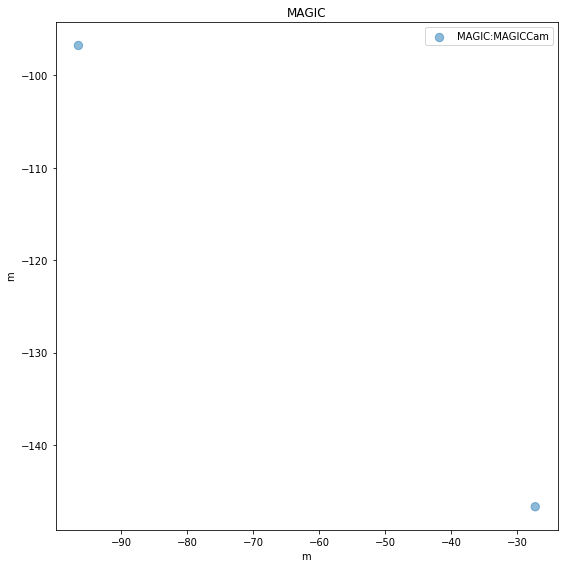

In [12]:
subarray = stereo_event.inst.subarray

print("M1 coordinates:")
print(stereo_event.inst.subarray.tel_coords[0])
print("M2 coordinates:")
print(stereo_event.inst.subarray.tel_coords[1])

subarray.peek()

## 3. Display the images

### Display stereo event images

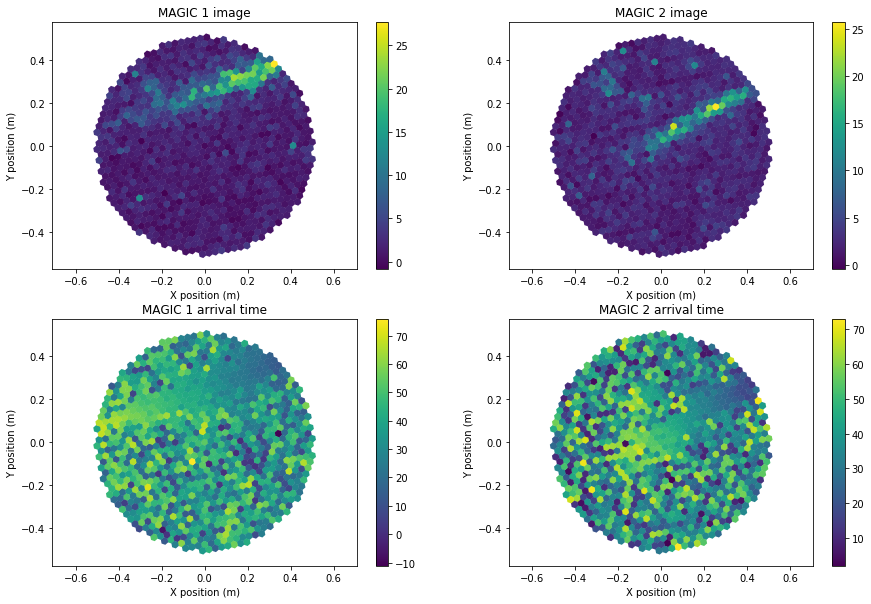

In [25]:
from ctapipe.visualization import CameraDisplay

# Cameras
m1_cam = stereo_event.inst.subarray.tel[1].camera
m2_cam = stereo_event.inst.subarray.tel[2].camera

# Charge images
m1_event_image = stereo_event.dl1.tel[1].image
m2_event_image = stereo_event.dl1.tel[2].image

# Peak position maps
m1_event_times = stereo_event.dl1.tel[1].peakpos
m2_event_times = stereo_event.dl1.tel[2].peakpos

fig1, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 10))

# M1 charge map
disp1 = CameraDisplay(m1_cam, m1_event_image, ax=ax1, title="MAGIC 1 image")
disp1.add_colorbar(ax=ax1)

# M2 charge map
disp2 = CameraDisplay(m2_cam, m2_event_image,  ax=ax2, title="MAGIC 2 image")
disp2.add_colorbar(ax=ax2)

# M1 peak pos map
disp3 = CameraDisplay(m1_cam, m1_event_times, ax=ax3, title="MAGIC 1 arrival time")
disp3.add_colorbar(ax=ax3)

# M2 peak pos map
disp4 = CameraDisplay(m2_cam, m2_event_times,  ax=ax4, title="MAGIC 2 arrival time")
disp4.add_colorbar(ax=ax4)

*Recall:* MARS - standard MAGIC analysis software - uses a different to simtel camera coordinate system.

We can display the same event in the MAGIC software *MARS* geometry:

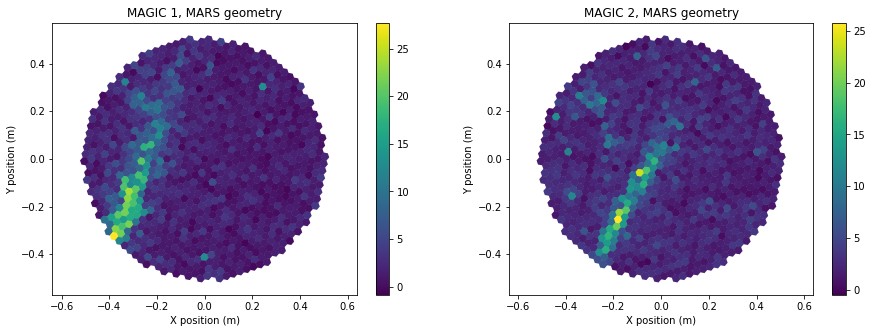

In [14]:
# An alternative way to get the required camera geometry - define a whole "telescope"

from ctapipe.instrument import TelescopeDescription
from ctapipe.instrument import OpticsDescription
from ctapipe.instrument import CameraGeometry

magic_tels_MARS = TelescopeDescription(optics=OpticsDescription.from_name('MAGIC'), 
                                       camera=CameraGeometry.from_name('MAGICCamMars'))

fig1, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# M1 charge map
disp1 = CameraDisplay(magic_tels_MARS.camera, m1_event_image, ax=ax1, title="MAGIC 1, MARS geometry")
disp1.add_colorbar(ax=ax1)

# M2 charge map
disp2 = CameraDisplay(magic_tels_MARS.camera, m2_event_image,  ax=ax2, title="MAGIC 2, MARS geometry")
disp2.add_colorbar(ax=ax2)

### Annimate all events in the data run
Finally, let's do a movie-like display loop through the events. 

**Wait till the end or abort by clicking on the stop sign above the notebook**

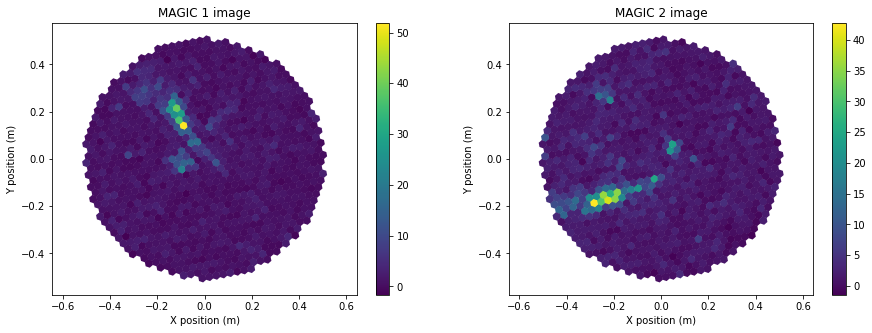

In [15]:
from IPython import display

fig2, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

# M1 charge map
disp1 = CameraDisplay(m1_cam, m1_event_image, ax=ax1, title="MAGIC 1 image")
disp1.add_colorbar(ax=ax1)

# M2 charge map
disp2 = CameraDisplay(m2_cam, m2_event_image,  ax=ax2, title="MAGIC 2 image")
disp2.add_colorbar(ax=ax2)

# Stereo event source
stereo_events = event_source(input_url=file_mask, max_events=50)

# Looping over the events
for event in stereo_events:
    
    disp1.image = event.dl1.tel[1].image
    disp2.image = event.dl1.tel[2].image
    
    display.clear_output(wait=True)
    display.display(plt.gcf())
    
    print("Stereo event ID {:d}".format(int(event.r0.event_id)))
    
    time.sleep(0.2)
    
display.clear_output()

### Display mono event images

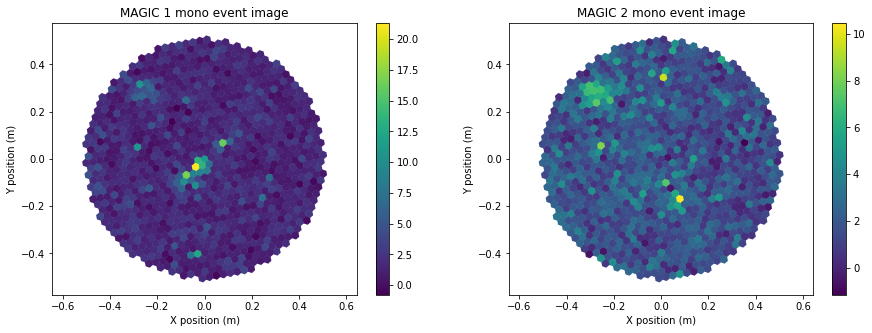

In [16]:
# Cameras
m1_cam = m1_mono_event.inst.subarray.tel[1].camera
m2_cam = m2_mono_event.inst.subarray.tel[2].camera

# Images
m1_event_image = m1_mono_event.dl1.tel[1].image
m2_event_image = m2_mono_event.dl1.tel[2].image

plt.figure(figsize=(15,5))

plt.subplot(121)
# M1 event charge map
disp = CameraDisplay(m1_cam, m1_event_image, title="MAGIC 1 mono event image")
disp.add_colorbar()

plt.subplot(122)
# M2 event charge map
disp = CameraDisplay(m2_cam, m2_event_image, title="MAGIC 2 mono event image")
disp.add_colorbar()

### Display pedestal event images

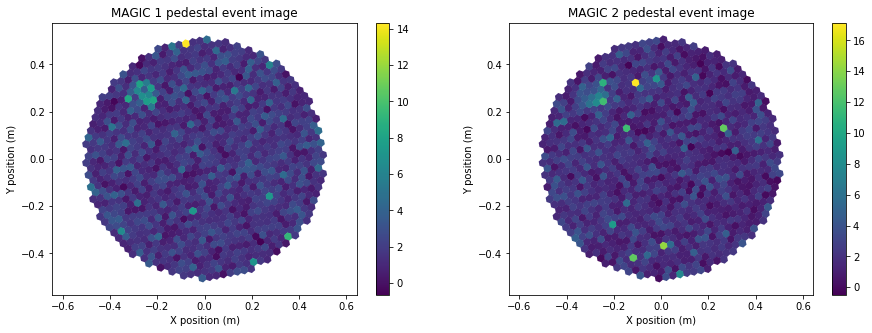

In [17]:
# Cameras
m1_cam = m1_ped_event.inst.subarray.tel[1].camera
m2_cam = m2_ped_event.inst.subarray.tel[2].camera

# Images
m1_event_image = m1_ped_event.dl1.tel[1].image
m2_event_image = m2_ped_event.dl1.tel[2].image

plt.figure(figsize=(15,5))

plt.subplot(121)
# M1 event charge map
disp = CameraDisplay(m1_cam, m1_event_image, title="MAGIC 1 pedestal event image")
disp.add_colorbar()

plt.subplot(122)
# M2 event charge map
disp = CameraDisplay(m2_cam, m2_event_image, title="MAGIC 2 pedestal event image")
disp.add_colorbar()

## 4. Read pointing & timing information

Here we will read the telescope pointing direction and trigger time for each stereo event in the run.

In [18]:
from astropy import units as u

# Containers
alt_vec = []; az_vec = []
ra_vec = []; dec_vec = []
trig_times = []

# Will use only stereo events
stereo_events = event_source(input_url=file_mask)

for event in stereo_events:
    # Pointing azimuthal coordinates
    alt_vec.append(event.pointing[1].altitude.to(u.deg).value)
    az_vec.append(event.pointing[1].azimuth.to(u.deg).value)
    
    # Pointing equatorial coordinates
    ra_vec.append(event.pointing[1].ra.to(u.deg).value)
    dec_vec.append(event.pointing[1].dec.to(u.deg).value)
    
    trig_times.append(event.trig.gps_time)
    
# Elapsed seconds since the first event
seconds_since_start = [(trig_times[i] - trig_times[0]).sec for i in range(len(trig_times))]

N.B.: here we have read the pointing of MAGIC 1. In principle, telescopes can point to different directions, but MAGICs don't (normally).

Let's display the telescope pointing over time:

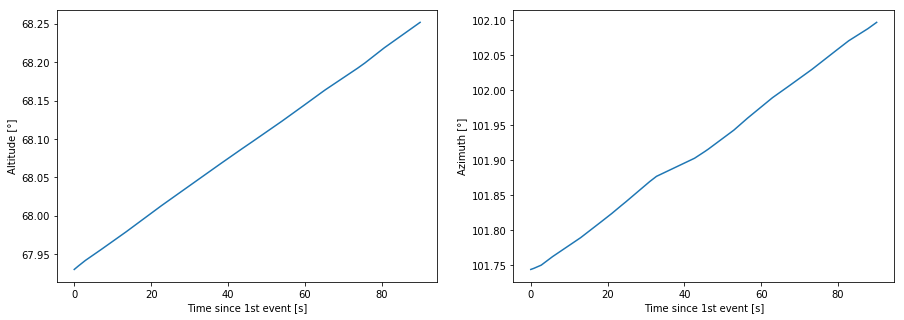

In [19]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(seconds_since_start, alt_vec)
plt.xlabel("Time since 1st event [s]")
plt.ylabel("Altitude [°]")

plt.subplot(122)
plt.plot(seconds_since_start, az_vec)
plt.xlabel("Time since 1st event [s]")
plt.ylabel("Azimuth [°]");

MAGIC data also already contain the corresponding RA-Dec coordinates of the pointing. From these the drive guiding accuracy (< 1 arcmin) can be seen (traced by the MAGIC star guider).

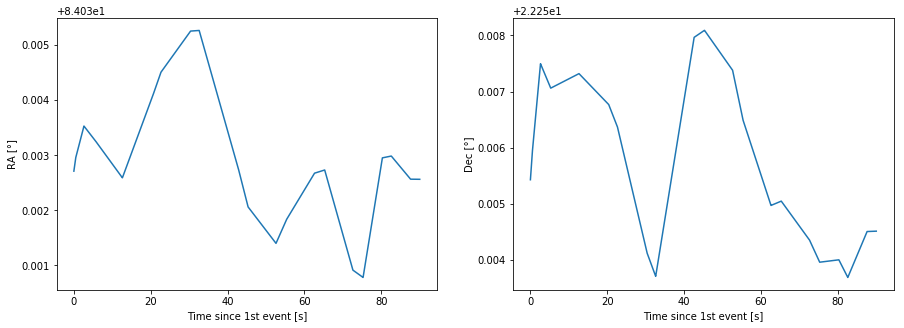

In [20]:
plt.figure(figsize=(15,5))

plt.subplot(121)
plt.plot(seconds_since_start, ra_vec)
plt.xlabel("Time since 1st event [s]")
plt.ylabel("RA [°]")

plt.subplot(122)
plt.plot(seconds_since_start, dec_vec)
plt.xlabel("Time since 1st event [s]")
plt.ylabel("Dec [°]");

## 5. Summary

 - Sim_telarray:
     - MAGICs and CTA telescopes can be jointly simulated;
 - ctapipe:
     - MAGICs + CTA MCs can be processed in a usual way;
     - MAGIC calibrated data can be loaded and processed;
     
$\rightarrow$ Common MAGICs + CTA observations / analysis possible.